### 3. Generación de Lenguaje Natural
Implementación de un modelo de generación de lenguaje utilizando algún dataset de los propuestos de Twitter.

El objetivo es el de simular la creación de un bot que escriba tweets de manera similar al del autor utilizado para el entrenamiento.

Se valorará principalmente la argumentación de los pasos realizados y las conclusiones al analizar los resultados y limitaciones encontradas.

Esta práctica se ha realizado en colab por lo que hay algunas celdas que no funcionaran el jupyeter o algunas rutas que no se corresponden una estructura de un sistema normal


In [1]:
# Importamos a lo que vayamos a necesitar

import numpy as np
import pandas as pd
import re
import random
from copy import deepcopy
import matplotlib.pyplot as plt
from matplotlib import cm

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
#  connectamos con drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Cargamos los datos

In [30]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP/KimKardashianTweets.csv')

In [31]:
data.head()

,Unnamed: 0,date,id,link,retweet,text,author
0,0,Oct 2,782694393216110592,/KimKardashian/status/782694393216110592,False,Hey guys! Meet my #KimKardashianGame character...,KimKardashian
1,1,Oct 2,782632831780618240,/KimKardashian/status/782632831780618240,False,This guy is always in my shot!pic.twitter.com/...,KimKardashian
2,2,Oct 2,782559825205071872,/KimKardashian/status/782559825205071872,False,Balenciaga. No make up today.pic.twitter.com/l...,KimKardashian
3,3,Oct 1,782260907900567552,/KimKardashian/status/782260907900567552,False,Kourtney and Kim Take Parispic.twitter.com/VXw...,KimKardashian
4,4,Oct 1,782259209459101696,/KimKardashian/status/782259209459101697,False,GIVENCHY COUTUREpic.twitter.com/jHxTIuHzzo,KimKardashian


In [32]:
data = data[['retweet', 'text', 'author']]

In [33]:
data.head()

,retweet,text,author
0,False,Hey guys! Meet my #KimKardashianGame character...,KimKardashian
1,False,This guy is always in my shot!pic.twitter.com/...,KimKardashian
2,False,Balenciaga. No make up today.pic.twitter.com/l...,KimKardashian
3,False,Kourtney and Kim Take Parispic.twitter.com/VXw...,KimKardashian
4,False,GIVENCHY COUTUREpic.twitter.com/jHxTIuHzzo,KimKardashian


### Preprocesado

In [34]:
# Definimos unas regex que emplearemos para eliminar los siguientes campos:
#  - Usuarios/Menciones
#  - Hashtag
#  - Urls
#  - Imagenes

user_regex = re.compile('@\w+| @\w+ ')
hashtag_regex = re.compile('#\w+| #\w+ ')
url_regex = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
pics_regex = re.compile('pic?.\w+.\w+\/\w+')

In [35]:
users = []
hashtags = []
urls = []
pics = []


texts = []
for text in data['text']:
    
    users.extend([it.strip()for it in user_regex.findall(text)])
    hashtags.extend([it.strip()for it in hashtag_regex.findall(text)])
    urls.extend([it.strip()for it in url_regex.findall(text)])
    pics.extend([it.strip()for it in pics_regex.findall(text)])
    
    aux = text
    aux = re.sub(pics_regex, '', aux)
    aux = re.sub(url_regex, '', aux) 
    aux = re.sub(user_regex.pattern, ' ', aux)
    aux = re.sub(hashtag_regex.pattern, ' ', aux)

    # aux = re.sub('¢|ä|é|ö|ú|ī|–|‘|’|“|”|=|<|>', '', aux)
    
    aux = aux.strip()

    texts.append(aux)

In [36]:
# Vemos como se ha quedado nuestro texto procesado
len(texts)

10688

In [37]:
# Combinamos los textos en una unica lista
text = r' '.join(texts)

In [38]:
#  Sacamos los caracteres que componen nuestro corpus
characters = sorted(list(set(text)))
n_to_char = {n:char for n, char in enumerate(characters)}
char_to_n = {char:n for n, char in enumerate(characters)}

print('Unique chars: {}'.format(len(characters)))

Unique chars: 123


In [39]:
print(characters)

['\t', '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\xa0', '\xad', '´', '¹', 'É', 'á', 'ã', 'é', 'ô', '\u200b', '\u200e', '\u200f', '–', '—', '‘', '’', '“', '”', '•', '…', '™', '♡', '♫', '\ue411', '\ue6b7', '\ue6b9', '\ue6e2', '\ue6e3', '\ue6eb']


###'Traducimos' nuestros datos a numero

In [40]:
# Definimos las constantes
window = 10

text = ' '.join(texts)

In [41]:
def text_conversion(text, ctn_dict, window=5, step=1):

    l = len(text) - window

    X = np.ndarray(shape=(l, window), dtype=int)
    
    Y = np.zeros(l, dtype=int)
    
    for i in range(0, l, step):
        sequence = text[i: i + window]
        label = text[i + window]
        
        X[i] =  np.asarray([ctn_dict[c] for c in sequence])
        Y[i] = ctn_dict[label]
        
    return X,Y

In [42]:
X, Y = text_conversion(text, char_to_n, window=window)

In [43]:
X_modified = np.reshape(X, (len(X), window, 1))
X_modified = X_modified / float(len(characters))
Y_modified = np_utils.to_categorical(Y)

In [44]:
Y_modified.shape

(696335, 123)

### Comenzamos con nuestro modelo

In [45]:
def plot_values(title, values, marker=None, plt=plt):
  cmap = cm.get_cmap('tab10', len(values))
  for i, (tit, vals) in enumerate(values):
    if marker:
      plt.plot(np.arange(0, len(vals)), vals, marker, color=cmap(i), label=tit)
    else: 
      plt.plot(np.arange(0, len(vals)), vals, color=cmap(i), label=tit)

  if hasattr(plt, 'xlabel'):
    plt.xlabel('Values #')
  else:
    plt.set_xlabel("Values #")

  if hasattr(plt, 'ylabel'):
    plt.ylabel(f"{title}")
  else:
    plt.set_ylabel(f"{title}")
  plt.legend()

In [46]:
def create_nlp_network(shape, otputs):

  model = Sequential()

  model.add(LSTM(700, input_shape=shape, return_sequences=True))
  model.add(Dropout(0.2))
  
  model.add(LSTM(700))
  model.add(Dropout(0.2))

  model.add(Dense(Y_modified.shape[1], activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam')

  return model


In [47]:
model = create_nlp_network(X_modified.shape[1:], Y_modified.shape[1])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10, 700)           1965600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 700)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 700)               3922800   
_________________________________________________________________
dropout_4 (Dropout)          (None, 700)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 123)               86223     
Total params: 5,974,623
Trainable params: 5,974,623
Non-trainable params: 0
_________________________________________________________________


In [49]:
history = model.fit(
    X_modified, Y_modified, 
    validation_split=0.05, 
    batch_size=256, 
    epochs=25).history

Train on 661518 samples, validate on 34817 samples
Epoch 1/25
661518/661518 [==============================] - 307s 464us/step - loss: 2.8211 - val_loss: 2.7276
Epoch 2/25
661518/661518 [==============================] - 306s 463us/step - loss: 2.5149 - val_loss: 2.4339
Epoch 3/25
661518/661518 [==============================] - 305s 462us/step - loss: 2.2942 - val_loss: 2.2409
Epoch 4/25
661518/661518 [==============================] - 307s 464us/step - loss: 2.1581 - val_loss: 2.1629
Epoch 5/25
661518/661518 [==============================] - 307s 464us/step - loss: 2.0606 - val_loss: 2.1444
Epoch 6/25
661518/661518 [==============================] - 308s 466us/step - loss: 1.9831 - val_loss: 2.1268
Epoch 7/25
661518/661518 [==============================] - 307s 465us/step - loss: 1.9186 - val_loss: 2.0473
Epoch 8/25
661518/661518 [==============================] - 307s 465us/step - loss: 1.8664 - val_loss: 2.0344
Epoch 9/25
661518/661518 [==============================] - 308s 465u

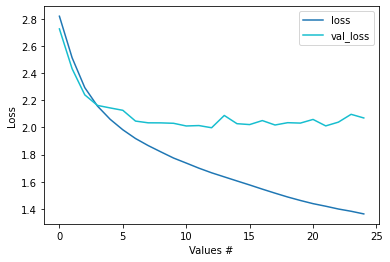

In [51]:
plot_values('Loss', [('loss', history['loss']), ('val_loss', history['val_loss'])])

In [52]:
def generate_text(model, initial_sequence):
    string_mapped = deepcopy(initial_sequence.tolist())
    full_string = [n_to_char[value] for value in string_mapped]
    
    # Generating characters
    # Generamos un tweet entre  280(el maximo actual de tweeter)
    characters_length = random.randint(len(string_mapped)+10, 280 )
    for i in range(characters_length):
        x = np.reshape(string_mapped,(1,len(string_mapped), 1))
        x = x / float(len(characters))

        pred_index = np.argmax(model.predict(x, verbose=0))
        seq = [n_to_char[value] for value in string_mapped]
        full_string.append(n_to_char[pred_index])

        string_mapped.append(pred_index)
        string_mapped = string_mapped[1:len(string_mapped)]
        
    text = ""
    for char in full_string:
        text = text + char
    return text

In [54]:
generate_text(model, X[0])

'Hey guys! I have to mane and start thooping a bommerci'

In [55]:
# Ahora exportaremos nuestro modelo para poder reutilizarlo posteriormente
def export_modoel(model, name):
  model.save(f"{name}.h5")
  
  !cp {name}.h5 /content/drive/My\ Drive/Colab\ Notebooks/NLP/{name}.h5

  print("Saved model to disk")

In [56]:
export_modoel(model, 'nlg_3')

Saved model to disk


Como conclusiones de esta practica llego a que después de probar varios modelos depende mucho de el numero de epocas y del preprocesado que hagas obener un texto 'natral', basicamente mi proceso sobre esta pŕactica ha sido el de copiar una estructura básica e iterar sobre ella añadirndo etapas en la limpieza y cambiando los parametros del entrenamiento 'batch_size' y 'epochs'.

El reusltado final se ve que no es muy 'optimo' pero ha sido mucho tiempo y varias pruebas para intetar crar un mdelo que genre lenguaje 'natual'